DATA PREDICTION MODEL

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [18]:
"""TO READ FILE"""
import os
os.chdir(r"C:\Users\Deonne\OneDrive - Nanyang Technological University\Desktop\Y2S1\Biohackathon")
#os.chdir(r"path")
print("Current working directory is:", os.getcwd())

#load clean data
clean_data = pd.read_csv('cleaned_cervical_cancer.csv')

Current working directory is: C:\Users\Deonne\OneDrive - Nanyang Technological University\Desktop\Y2S1\Biohackathon


In [19]:
#define target variable
target = 'Dx:Cancer'
X = clean_data.drop(columns=[target])
Y = clean_data[target]

In [20]:
#split data
X_training, X_testing, Y_training, Y_testing = train_test_split(X, Y, test_size=0.2, random_state=42)
#standardise features
scaler = StandardScaler()
X_training_scaled = scaler.fit_transform(X_training)
X_testing_scaled = scaler.transform(X_testing)

In [21]:
#define models
models = {
    "Logistics Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced',random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

Evalutaion

In [22]:
#train + evaluate models
result = []
fitted_models = {}

for name, model in models.items():
    print(f"Training {name}:")
    model.fit(X_training_scaled, Y_training)
    fitted_models[name] = model

    Y_prediction = model.predict(X_testing_scaled)
    if hasattr(model, "predict_proba"):
        Y_probability = model.predict_proba(X_testing_scaled)[:, 1]
    else:
        Y_probability = None

    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy_score(Y_testing, Y_prediction):.4f}")
    print(f"Precision: {precision_score(Y_testing, Y_prediction):.4f}")
    print(f"Recall: {recall_score(Y_testing, Y_prediction):.4f}")
    print(f"F1 Score: {f1_score(Y_testing, Y_prediction):.4f}")

    print(classification_report(Y_testing, Y_prediction))

Training Logistics Regression:
Results for Logistics Regression:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00         6

    accuracy                           1.00       164
   macro avg       1.00      1.00      1.00       164
weighted avg       1.00      1.00      1.00       164

Training Random Forest:
Results for Random Forest:
Accuracy: 0.9878
Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8000
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       158
           1       1.00      0.67      0.80         6

    accuracy                           0.99       164
   macro avg       0.99      0.83      0.90       164
weighted avg       0.99      0.99      0.99       164



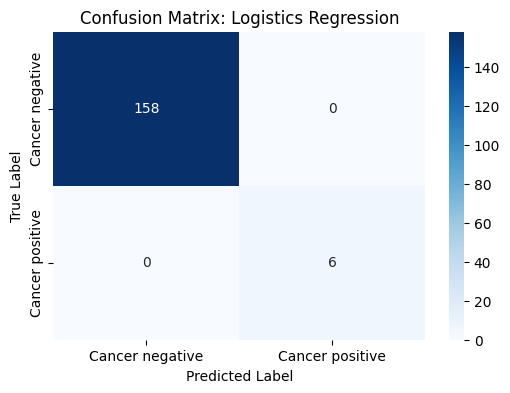

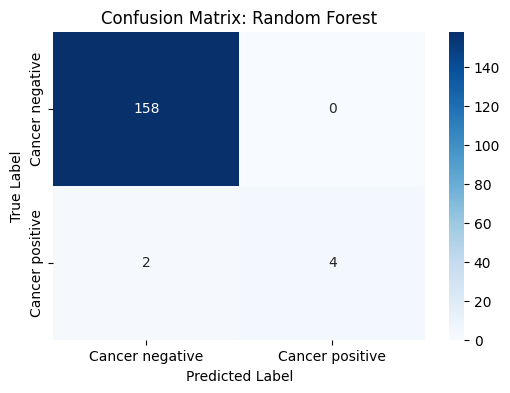

In [23]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
for name, model in fitted_models.items():
    Y_predicted = model.predict(X_testing_scaled)
    confusion_mtx = confusion_matrix(Y_testing, Y_predicted)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_mtx, 
        annot=True, 
        fmt='d', 
        cmap="Blues", 
        xticklabels=['Cancer negative', 'Cancer positive'], 
        yticklabels=['Cancer negative', 'Cancer positive']
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

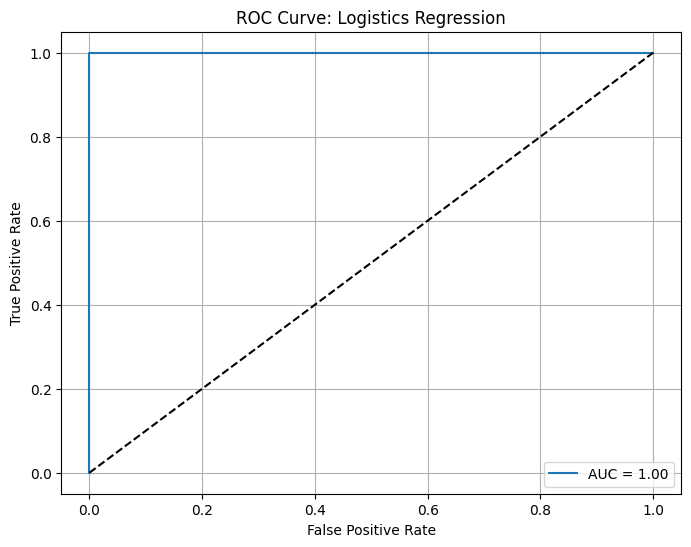

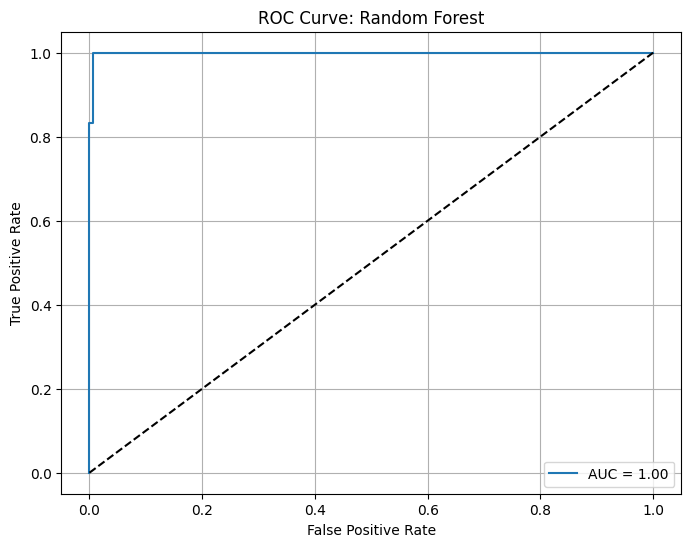

In [24]:
#ROC Curve
from sklearn.metrics import roc_curve, auc

for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_testing_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(Y_testing, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve: {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.show()